# Reference Code
+ Paper: https://arxiv.org/pdf/1701.03551.pdf
+ https://blog.scaleway.com/active-learning-pytorch/
+ https://github.com/dhaalves/CEAL_keras/blob/master/CEAL_keras.py
+ http://www.robertmunro.com/
+ https://github.com/ej0cl6/deep-active-learning
+ Book: https://www.manning.com/books/human-in-the-loop-machine-learning
+ https://github.com/ej0cl6/deep-active-learning

## ¿ Questions?
+ What would happen if I add another source dataset?
+ Validation Data -> Should be added the uncertain and confidence sample in validation?
+  How can we approach that test has different distribution 

## 1. Importing Libraries

In [1]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import yaml
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import matplotlib.pyplot as plt
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from utils.ModelPrediction import get_prediction,get_probs,run_metrics
from utils.ActiveLearning import get_high_confidence_samples,get_uncertain_samples
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset, EvalImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass
from sklearn.model_selection import train_test_split
# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from pytorch_lightning import Trainer
# 4. Wandb Tracker Experiements
import wandb

In [3]:
BASE_IMG_DIR    = '/mnt/subfigure-classification'
SEED            = 42
METRIC_MONITOR  = "val_avg_loss"
MODE_METRIC     = 'min'
CRITERIA        = 'ms'     
CEAL            = False
SAMPLES         = 500
DELTA           = 0.005
DELTA_RATIO     = 0.00033
MAXIMUM_INTERATIONS = 10
MAX_EPOCHS      = 100 
LEARNING_RATE   = 1e-4
NAME_EXPERIMENT = 'Experiment_A'
SAVE_AL_DATA    = os.path.join('../data/ActiveLearning',NAME_EXPERIMENT)
OUTPUT_DIR      = os.path.join('/mnt/artifacts/active_learning/higher_modality',NAME_EXPERIMENT)
BATCH_SIZE      = 32
NUM_WORKERS     = 32
RESNET_MODEL    = 'resnet50'
os.makedirs(SAVE_AL_DATA,exist_ok=True)
os.makedirs(OUTPUT_DIR,exist_ok=True)

# Saving Parameter for Running


## 2. Functions

In [4]:
def initialize_dataset(csv_route,new_col='split_set_al',modaliy_col = 'higher_modality',high_condidence_col = 'High_Confidence_Samples'):
    df           = pd.read_csv(csv_route,sep = '\t')
    df_labeled   = df[df['labeled']=='LABELED'].reset_index(drop = True)
    df_unlabaled = df[df['labeled']=='UNLABELED'].reset_index(drop = True)
    df_test      = df[df['labeled']=='TEST'].reset_index(drop = True)
    df_test[new_col] = df_test['labeled']
    df_train_labeled,df_val_labeled,_,_ = train_test_split(df_labeled.copy(),df_labeled[modaliy_col].copy(),random_state=SEED)
    df_train_labeled[new_col] = 'TRAIN'
    df_val_labeled[new_col]   = 'VAL'
    df_start_labeled   = pd.concat([df_train_labeled,df_val_labeled,df_test]).reset_index(drop = True)
    df_start_labeled[high_condidence_col] = 0
    df_start_unlabaled = df_unlabaled.copy()
    
    
    df_start_labeled.to_csv(os.path.join(SAVE_AL_DATA,'Labeled_Pool_0.csv'),index = False,sep = '\t')
    df_start_unlabaled.to_csv(os.path.join(SAVE_AL_DATA,'Unlabeled_Pool.csv'),index = False,sep = '\t')

In [5]:
def split_dataset(df_labeled,col= 'split_set_al',modaliy_col = 'higher_modality'):
    df_train_labeled,df_val_labeled,_,_ = train_test_split(df_labeled.copy(),df_labeled[modaliy_col].copy(),random_state=SEED)
    df_train_labeled[col] = 'TRAIN'
    df_val_labeled[col]   = 'TRAIN'
    return pd.concat([df_train_labeled,df_val_labeled]).reset_index(drop = True)

## 3. Dividing Dataset For Experiments

+ We can do a 20% split set
+ We start with a 10% of labeled images that would be extracted in a stratified way and then we would keep adding images from the unlabeled batch

In [6]:
'''
df_higher_modality     = pd.read_csv('../data/higher_modality_vol1.csv',sep = '\t').drop(columns = ['caption','split_set'])
df_hm_train,df_hm_test = df_higher_modality[df_higher_modality['set']=='TRAIN'].reset_index(drop = True), df_higher_modality[df_higher_modality['set']=='TEST'].reset_index(drop = True)
df_hm_train['labeled'] = 'UNLABELED'
mskf = MultilabelStratifiedKFold(n_splits = 10, shuffle = False,random_state=None)
for fold,(train_index, test_index) in enumerate(mskf.split(df_hm_train, df_hm_train['higher_modality'])):
    if fold == 0:   
        df_hm_train.loc[test_index,'labeled'] = 'LABELED'

# Dataset for Active Learning
df_al = pd.concat([df_hm_train,df_hm_test],axis = 0)
df_al['labeled'] = df_al['labeled'].fillna('TEST') # For Test Set
df_al.to_csv('../data/higher_modality_al.csv',sep = '\t',index = False)
'''

"\ndf_higher_modality     = pd.read_csv('../data/higher_modality_vol1.csv',sep = '\t').drop(columns = ['caption','split_set'])\ndf_hm_train,df_hm_test = df_higher_modality[df_higher_modality['set']=='TRAIN'].reset_index(drop = True), df_higher_modality[df_higher_modality['set']=='TEST'].reset_index(drop = True)\ndf_hm_train['labeled'] = 'UNLABELED'\nmskf = MultilabelStratifiedKFold(n_splits = 10, shuffle = False,random_state=None)\nfor fold,(train_index, test_index) in enumerate(mskf.split(df_hm_train, df_hm_train['higher_modality'])):\n    if fold == 0:   \n        df_hm_train.loc[test_index,'labeled'] = 'LABELED'\n\n# Dataset for Active Learning\ndf_al = pd.concat([df_hm_train,df_hm_test],axis = 0)\ndf_al['labeled'] = df_al['labeled'].fillna('TEST') # For Test Set\ndf_al.to_csv('../data/higher_modality_al.csv',sep = '\t',index = False)\n"

In [7]:
df_higher_modality     = pd.read_csv('../data/higher_modality_vol1.csv',sep = '\t').drop(columns = ['caption','split_set'])
df_higher_modality['split_set'] = 'TRAIN'
df_higher_modality['labeled']   = 'UNLABELED'
mskf = MultilabelStratifiedKFold(n_splits = 10, shuffle = False,random_state=None)
for fold,(train_index, test_index) in enumerate(mskf.split(df_higher_modality, df_higher_modality[['source','higher_modality']])):
    if (fold == 0):   
        df_higher_modality.loc[test_index,'split_set'] = 'VAL'
        df_higher_modality.loc[test_index,'labeled']   = 'LABELED'
    elif (fold == 1)|(fold == 2):   
        df_higher_modality.loc[test_index,'split_set']   = 'TEST'
        df_higher_modality.loc[test_index,'labeled']   = 'LABELED'
    else:
        df_higher_modality.loc[test_index,'split_set']   = 'TRAIN'

# Dataset for Active Learning

df_higher_train = df_higher_modality[df_higher_modality['split_set']=='TRAIN'].reset_index(drop = True)
df_higher_rest  = df_higher_modality[df_higher_modality['split_set']!='TRAIN'].reset_index(drop = True)
mskf = MultilabelStratifiedKFold(n_splits = 20, shuffle = False,random_state=None)
for fold,(train_index, test_index) in enumerate(mskf.split(df_higher_train, df_higher_train[['source','higher_modality']])):
    if fold == 0:   
        df_higher_train.loc[test_index,'labeled'] = 'LABELED'


# Dataset for Active Learning
df_al = pd.concat([df_higher_train,df_higher_rest],axis = 0)
df_al['split_set_al'] = df_al['split_set']
df_al.to_csv('../data/higher_modality_al.csv',sep = '\t',index = False)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [8]:
df_al.split_set.value_counts(normalize = True)

TRAIN    0.699958
TEST     0.200028
VAL      0.100014
Name: split_set, dtype: float64

## Active Learning

## 1.Initialization

In [13]:
# 1. Generate the pool of labeled Data & Unlabaled data
df_higher_modality_al = pd.read_csv('../data/higher_modality_al.csv',sep= '\t')
#initialize_dataset('../data/higher_modality_al.csv')
df_start_labeled   = df_higher_modality_al[df_higher_modality_al['labeled']=='LABELED'].reset_index(drop= True )
df_start_labeled['High_Confidence_Samples'] = 0

df_start_unlabaled = df_higher_modality_al[df_higher_modality_al['labeled']=='UNLABELED'].reset_index(drop= True )
df_start_labeled.to_csv(os.path.join(SAVE_AL_DATA,'Labeled_Pool_0.csv'),index = False,sep = '\t')
df_start_unlabaled.to_csv(os.path.join(SAVE_AL_DATA,'Unlabeled_Pool.csv'),index = False,sep = '\t')


df_unlabeled = pd.read_csv(os.path.join(SAVE_AL_DATA,f'Unlabeled_Pool.csv'),sep = '\t').reset_index(drop = True)
# 2. Get the Label Encoder & Num Classes
le_encoder,dict_label = label_encoder_target(df_higher_modality_al)
num_classes = len(dict_label)
print(f'Label Encoder: {dict_label}')

Label Encoder: {'EXPERIMENTAL': 0, 'GRAPHICS': 1, 'MICROSCOPY': 2, 'MOLECULAR': 3, 'ORGANISMS': 4, 'OTHER': 5}


In [14]:
df_start_labeled.shape,df_unlabeled.shape

((4814, 10), (9554, 9))

In [15]:
print(f'Initial Labeled Dataset shape: {pd.read_csv(os.path.join(SAVE_AL_DATA,"Labeled_Pool_0.csv")).shape}')
print(f'Initial Unlabaled Dataset shape: {pd.read_csv(os.path.join(SAVE_AL_DATA,"Unlabeled_Pool.csv")).shape}')

Initial Labeled Dataset shape: (4814, 1)
Initial Unlabaled Dataset shape: (9554, 1)


********** Active Learning CEAL **********
********** Iteration 1 **********
Shape of the Labeled Dataset (4814, 10)
Shape of the Train Dataset (503, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.6521, 0.6477, 0.6457]), Std of the Dataset: tensor([0.3736, 0.3732, 0.3770]) 


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 87.71746826171875
              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78       118
         1.0       0.92      0.93      0.92      1070
         2.0       0.92      0.88      0.90       651
         3.0       0.72      0.57      0.64       164
         4.0       0.92      0.95      0.93       714
         5.0       0.50      0.52      0.51       157

    accuracy                           0.88      2874
   macro avg       0.78      0.79      0.78      2874
weighted avg       0.88      0.88      0.88      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.7861680914399396,
 'Macro F1-Score': 0.7817597409900197,
 'Macro Precision': 0.7827273909750104,
 'Macro Recall': 0.7861680914399396,
 'test_acc': tensor(87.7175, device='cuda:0'),
 'test_loss': tensor(0.4857, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.0046700000000000005
Uncertainty Samples 500
********** Iteration 2 **********
Shape of the Labeled Dataset (5314, 10)
Shape of the Train Dataset (1003, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.6875, 0.6816, 0.6779]), Std of the Dataset: tensor([0.3593, 0.3590, 0.3649]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_1 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 89.45720672607422
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88       118
         1.0       0.96      0.93      0.94      1070
         2.0       0.96      0.88      0.92       651
         3.0       0.57      0.79      0.66       164
         4.0       0.91      0.97      0.94       714
         5.0       0.63      0.42      0.51       157

    accuracy                           0.89      2874
   macro avg       0.81      0.83      0.81      2874
weighted avg       0.90      0.89      0.89      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.825717560148444,
 'Macro F1-Score': 0.8082286739494591,
 'Macro Precision': 0.8068025090094167,
 'Macro Recall': 0.825717560148444,
 'test_acc': tensor(89.4572, device='cuda:0'),
 'test_loss': tensor(0.3478, device='cuda:0')}
-----------------------------------------------------------------------


DELTA: 0.00434
Uncertainty Samples 500
********** Iteration 3 **********
Shape of the Labeled Dataset (5814, 10)
Shape of the Train Dataset (1503, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.6952, 0.6888, 0.6851]), Std of the Dataset: tensor([0.3542, 0.3554, 0.3606]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_2 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 93.00626373291016
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       118
         1.0       0.96      0.96      0.96      1070
         2.0       0.94      0.95      0.95       651
         3.0       0.75      0.82      0.78       164
         4.0       0.97      0.96      0.97       714
         5.0       0.76      0.58      0.66       157

    accuracy                           0.93      2874
   macro avg       0.87      0.87      0.87      2874
weighted avg       0.93      0.93      0.93      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8736447685393446,
 'Macro F1-Score': 0.8692657160785813,
 'Macro Precision': 0.8710841901892317,
 'Macro Recall': 0.8736447685393446,
 'test_acc': tensor(93.0063, device='cuda:0'),
 'test_loss': tensor(0.2629, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.00401
Uncertainty Samples 500
********** Iteration 4 **********
Shape of the Labeled Dataset (6314, 10)
Shape of the Train Dataset (2003, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.6989, 0.6926, 0.6889]), Std of the Dataset: tensor([0.3510, 0.3530, 0.3581]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_3 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 92.27557373046875
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89       118
         1.0       0.97      0.93      0.95      1070
         2.0       0.96      0.93      0.95       651
         3.0       0.78      0.82      0.80       164
         4.0       0.94      0.97      0.96       714
         5.0       0.64      0.69      0.67       157

    accuracy                           0.92      2874
   macro avg       0.85      0.89      0.87      2874
weighted avg       0.93      0.92      0.92      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8873532185486747,
 'Macro F1-Score': 0.8693902317530392,
 'Macro Precision': 0.8542388116056765,
 'Macro Recall': 0.8873532185486747,
 'test_acc': tensor(92.2756, device='cuda:0'),
 'test_loss': tensor(0.2616, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.0036799999999999997
Uncertainty Samples 500
********** Iteration 5 **********
Shape of the Labeled Dataset (6814, 10)
Shape of the Train Dataset (2503, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.7149, 0.7102, 0.7061]), Std of the Dataset: tensor([0.3474, 0.3484, 0.3535]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_4 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 91.68406677246094
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93       118
         1.0       0.97      0.91      0.94      1070
         2.0       0.98      0.92      0.95       651
         3.0       0.60      0.81      0.69       164
         4.0       0.94      0.99      0.96       714
         5.0       0.66      0.68      0.67       157

    accuracy                           0.92      2874
   macro avg       0.84      0.88      0.86      2874
weighted avg       0.93      0.92      0.92      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8789847693105243,
 'Macro F1-Score': 0.8579729890781417,
 'Macro Precision': 0.8430970441363713,
 'Macro Recall': 0.8789847693105243,
 'test_acc': tensor(91.6841, device='cuda:0'),
 'test_loss': tensor(0.2769, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.0033499999999999997
Uncertainty Samples 500
********** Iteration 6 **********
Shape of the Labeled Dataset (7314, 10)
Shape of the Train Dataset (3003, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.7195, 0.7152, 0.7115]), Std of the Dataset: tensor([0.3443, 0.3452, 0.3499]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_5 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 92.93667602539062
              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87       118
         1.0       0.99      0.93      0.96      1070
         2.0       0.97      0.94      0.95       651
         3.0       0.78      0.79      0.79       164
         4.0       0.97      0.96      0.97       714
         5.0       0.63      0.78      0.69       157

    accuracy                           0.93      2874
   macro avg       0.85      0.90      0.87      2874
weighted avg       0.94      0.93      0.93      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9005348615114328,
 'Macro F1-Score': 0.8709669206934433,
 'Macro Precision': 0.8490796397848858,
 'Macro Recall': 0.9005348615114328,
 'test_acc': tensor(92.9367, device='cuda:0'),
 'test_loss': tensor(0.2236, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.0030199999999999997
Uncertainty Samples 500
********** Iteration 7 **********
Shape of the Labeled Dataset (7814, 10)
Shape of the Train Dataset (3503, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.7048, 0.6997, 0.6956]), Std of the Dataset: tensor([0.3504, 0.3512, 0.3560]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_6 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 93.04106140136719
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       118
         1.0       0.98      0.92      0.95      1070
         2.0       0.97      0.95      0.96       651
         3.0       0.72      0.87      0.79       164
         4.0       0.96      0.97      0.96       714
         5.0       0.65      0.76      0.70       157

    accuracy                           0.93      2874
   macro avg       0.87      0.91      0.88      2874
weighted avg       0.94      0.93      0.93      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9052790322791653,
 'Macro F1-Score': 0.8836107649671491,
 'Macro Precision': 0.8661308226205199,
 'Macro Recall': 0.9052790322791653,
 'test_acc': tensor(93.0411, device='cuda:0'),
 'test_loss': tensor(0.2219, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.0026899999999999997
Uncertainty Samples 500
********** Iteration 8 **********
Shape of the Labeled Dataset (8314, 10)
Shape of the Train Dataset (4003, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.7070, 0.7021, 0.6992]), Std of the Dataset: tensor([0.3469, 0.3475, 0.3516]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_7 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 93.28462219238281
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.91       118
         1.0       0.97      0.95      0.96      1070
         2.0       0.97      0.95      0.96       651
         3.0       0.81      0.77      0.79       164
         4.0       0.97      0.97      0.97       714
         5.0       0.62      0.76      0.68       157

    accuracy                           0.93      2874
   macro avg       0.87      0.89      0.88      2874
weighted avg       0.94      0.93      0.93      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8923784598238894,
 'Macro F1-Score': 0.8791678115166843,
 'Macro Precision': 0.8694180913108905,
 'Macro Recall': 0.8923784598238894,
 'test_acc': tensor(93.2846, device='cuda:0'),
 'test_loss': tensor(0.2656, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.0023599999999999997
Uncertainty Samples 500
********** Iteration 9 **********
Shape of the Labeled Dataset (8814, 10)
Shape of the Train Dataset (4503, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.6985, 0.6932, 0.6896]), Std of the Dataset: tensor([0.3496, 0.3500, 0.3548]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_8 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 93.21503448486328
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       118
         1.0       0.97      0.94      0.96      1070
         2.0       0.98      0.94      0.96       651
         3.0       0.72      0.79      0.75       164
         4.0       0.97      0.98      0.98       714
         5.0       0.62      0.75      0.68       157

    accuracy                           0.93      2874
   macro avg       0.86      0.89      0.88      2874
weighted avg       0.94      0.93      0.93      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8943038751915781,
 'Macro F1-Score': 0.8753954586168753,
 'Macro Precision': 0.8597112601191684,
 'Macro Recall': 0.8943038751915781,
 'test_acc': tensor(93.2150, device='cuda:0'),
 'test_loss': tensor(0.2422, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.0020299999999999997
Uncertainty Samples 500
********** Iteration 10 **********
Shape of the Labeled Dataset (9314, 10)
Shape of the Train Dataset (5003, 10)
1. Calculate the Mean & Standard Deviation 



Mean of the Dataset: tensor([0.7023, 0.6985, 0.6938]), Std of the Dataset: tensor([0.3529, 0.3517, 0.3581]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_A/iteration_9 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 93.98051452636719
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91       118
         1.0       0.97      0.95      0.96      1070
         2.0       0.94      0.98      0.96       651
         3.0       0.83      0.82      0.83       164
         4.0       0.99      0.94      0.96       714
         5.0       0.72      0.78      0.75       157

    accuracy                           0.94      2874
   macro avg       0.88      0.91      0.89      2874
weighted avg       0.94      0.94      0.94      2874


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9102000022997782,
 'Macro F1-Score': 0.8949903642832989,
 'Macro Precision': 0.8823557192856887,
 'Macro Recall': 0.9102000022997782,
 'test_acc': tensor(93.9805, device='cuda:0'),
 'test_loss': tensor(0.2231, device='cuda:0')}
---------------------------------------------------------------------


DELTA: 0.0016999999999999997
Uncertainty Samples 500


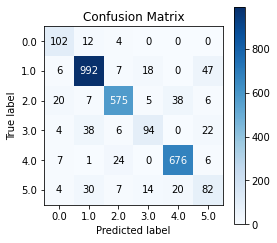

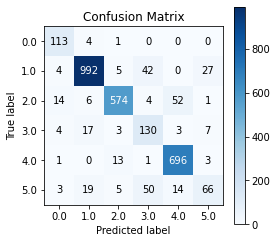

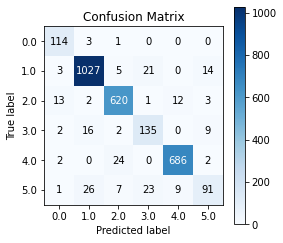

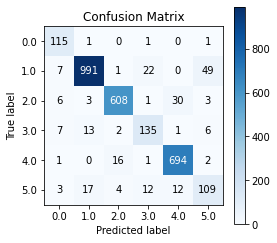

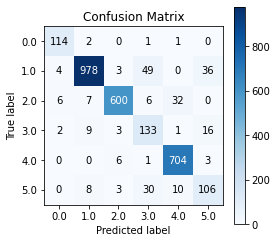

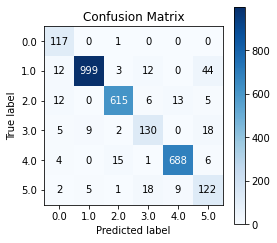

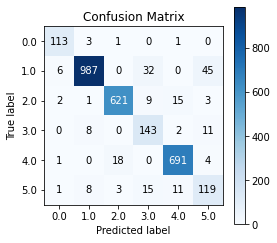

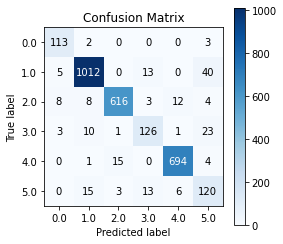

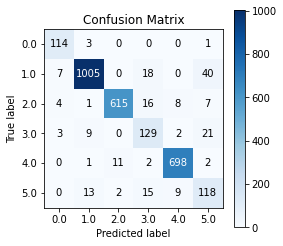

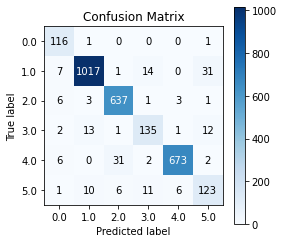

In [16]:
print(f"{'*'*10} Active Learning CEAL {'*'*10}")
for it in range(MAXIMUM_INTERATIONS):
    print(f"{'*'*10} Iteration {it+1} {'*'*10}")
    df = pd.read_csv(os.path.join(SAVE_AL_DATA,f'Labeled_Pool_{it}.csv'),sep='\t')
    print(f'Shape of the Labeled Dataset',df[df['labeled']=='LABELED'].shape)
    print(f'Shape of the Train Dataset',df[(df['labeled']=='LABELED')&(df['split_set']=='TRAIN')].shape)
    del df
    
    # 1. Calculate the Mean and Standard Deviation
    print('1. Calculate the Mean & Standard Deviation ')
    # Transformations for mean_std
    transform_mean_std =  transforms.Compose([
                                             transforms.ToPILImage(),
                                             transforms.Resize((224, 224)),
                                             transforms.ToTensor()])
    
    train_dataset   = ImageDataset    (os.path.join(SAVE_AL_DATA,f'Labeled_Pool_{it}.csv'),
                                      le_encoder,
                                      str(BASE_IMG_DIR),
                                      'TRAIN',
                                      image_transform  = transform_mean_std,
                                      label_name       = 'higher_modality',
                                      target_class_col = 'split_set_al',
                                      path_col         = 'img_path')
    

    mean, std =calc_dataset_mean_std(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    print(f"Mean of the Dataset: {mean}, Std of the Dataset: {std} ")

    # 2. Generate the Dataset
    
    # 2.1 Transformations for Train & Validation
    train_transform = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(15),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean,std)
                    ])

    val_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean,std)
                    ])

    # 2.2 Load the DataModule (Train,Val,Test dataloader)
    dm = ImageDataModule( batch_size       = BATCH_SIZE,
                          label_encoder    = le_encoder,
                          data_path        = os.path.join(SAVE_AL_DATA,f'Labeled_Pool_{it}.csv'),
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,val_transform],
                          num_workers      = NUM_WORKERS,
                          target_class_col ='split_set_al',
                          modality_col     ='higher_modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()

    
    # 2. Modeling
    # 2.1 Loading the ResnNet Model
    model = ResNetClass      (name            = RESNET_MODEL,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = 'whole',
                              lr              = LEARNING_RATE,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = None,
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean,
                              std_dataset     = std)

    # 2.2 Set Call-backs (EarlyStopping, ModelCheckpoint)
    
    early_stop_callback = EarlyStopping(
        monitor   = METRIC_MONITOR,
        min_delta = 0.0,
        patience  = 5,
        verbose   = True,
        mode      = MODE_METRIC
    )

    
    
    checkpoint_callback = ModelCheckpoint(dirpath    = os.path.join(OUTPUT_DIR,f'iteration_{it}'),
                                          monitor    = METRIC_MONITOR,
                                          mode       = MODE_METRIC,
                                          save_top_k = 1)
    
    
    # 3.3 Setup Trainer
    trainer = Trainer(gpus=1,
                      max_epochs = MAX_EPOCHS,
                      callbacks=[checkpoint_callback,early_stop_callback],
                      deterministic= True,
                      logger = None,
                      num_sanity_val_steps=0)
    
    trainer.fit(model, dm)
        
    del model,trainer
    
    # 3.5 Evaluate on the Test Set (Save Metrics):
    model_test = ResNetClass.load_from_checkpoint(checkpoint_callback.best_model_path)
    trainer_test = Trainer(gpus=1, logger=None)
    trainer_test.test(model_test, test_dataloaders=dm.test_dataloader())
    del trainer_test
    # Saving Some Metrics
    df_test = pd.read_csv(os.path.join(SAVE_AL_DATA,f'Labeled_Pool_{it}.csv'),sep = '\t')
    df_test = df_test[df_test['split_set_al']=='TEST'].reset_index(drop = True)
    test_dataset = EvalImageDataset (df_test,
                                     base_img_dir = '/mnt/subfigure-classification/',
                                     image_transform=val_transform,
                                     path_col='img_path')

    test_dataloader = DataLoader( dataset     = test_dataset,
                                  batch_size  = BATCH_SIZE,
                                  shuffle     = False,
                                  num_workers = NUM_WORKERS)
    #run_metrics(df_metrics,le_encoder.transform(df_test.higher_modality),get_prediction(test_dataloader,model_test.to('cuda'),'cuda'),it+1)
    #df_metrics.to_csv(os.path.join(SAVE_AL_DATA,'metrics.csv'),sep = '\t',index = False)
    # 4. Evaluate on the pool unlabeled data
    
    
    
    df_unlabeled_it = df_unlabeled.copy()
    print(f'Shape of the unlabeled pool: {df_unlabeled_it.shape}')
    df_unlabeled_it['img_path'] = df_unlabeled_it['img_path'].apply(lambda x: BASE_IMG_DIR +'/'+ x)
    unlabeled_dataset    = EvalImageDataset (df_unlabeled_it,
                                            image_transform=val_transform,
                                            path_col='img_path')

    unlabeled_dataloader = DataLoader(dataset     = unlabeled_dataset,
                                      batch_size  = BATCH_SIZE,
                                      shuffle     = False,
                                      num_workers = NUM_WORKERS)
    
    unlabeled_probs = get_probs(unlabeled_dataloader,model_test.to('cuda'),'cuda')
    # 4.1 Get the most uncertain examples and the most confident
    # Getting the dataset for training and validation -- Check indexes
    _,un_idx       = get_uncertain_samples(unlabeled_probs, SAMPLES,CRITERIA)
    df_uncertain = df_unlabeled_it.loc[un_idx,:].reset_index(drop = True) # Check the use of loc
    df_uncertain['labeled']   = 'LABELED'
    df_uncertain['split_set'] = 'TRAIN'
    df_uncertain['High_Confidence_Samples'] = 0
    DELTA = DELTA - DELTA_RATIO
    print(f'DELTA: {DELTA}')
    
    hc_idx,hc_labels = get_high_confidence_samples(unlabeled_probs,DELTA)
    
    #df_confidence    = df_unlabeled_it.loc[np.array(list(set(hc_idx)-set(un_idx))),:].copy()
    #df_confidence.loc[np.array(list(set(hc_idx)-set(un_idx))),'higher_modality'] = le_encoder.inverse_transform(hc_labels) # Check the loc
    #df_confidence = df_confidence.reset_index(drop = True)
    #df_confidence['High_Confidence_Samples'] = 1
    
    
    df_confidence    = df_unlabeled_it.loc[hc_idx,:].copy()
    df_confidence.loc[hc_idx,'higher_modality'] = le_encoder.inverse_transform(hc_labels) # Check the loc
    df_confidence    = df_confidence.loc[np.array(list(set(hc_idx)-set(un_idx))),:].reset_index(drop = True)
    df_confidence['High_Confidence_Samples'] = 1
    
    # Drop the uncertainty data from the Unlabeled Pool
    df_unlabeled.drop(df_unlabeled.index[np.array(list(un_idx))],inplace = True)
    df_unlabeled = df_unlabeled.reset_index(drop = True)
    
    if CEAL:
        df_new_labeled_pool            = pd.concat([df_uncertain,df_confidence]).reset_index(drop = True)
        df_new_labeled_pool['labeled'] = 'LABELED'
        df_new_labeled_pool            = split_dataset(df_new_labeled_pool)
        print(f"Uncertainty Samples {df_uncertain.shape[0]}, High Confidence Samples: {df_confidence.shape}")

    else:    
        df_new_labeled_pool            = df_uncertain.copy()
        df_new_labeled_pool            = split_dataset(df_new_labeled_pool)
        print(f"Uncertainty Samples {df_uncertain.shape[0]}")
    df_actual_labeled = pd.read_csv(os.path.join(SAVE_AL_DATA,f'Labeled_Pool_{it}.csv'),sep = '\t')
    df_actual_labeled = df_actual_labeled[df_actual_labeled['High_Confidence_Samples']==0].reset_index(drop = True)
    pd.concat([df_actual_labeled,df_new_labeled_pool[df_actual_labeled.columns]]).reset_index(drop = True).to_csv(os.path.join(SAVE_AL_DATA,f'Labeled_Pool_{it+1}.csv'),sep ='\t',index = False)